In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.feature.nightshade import Nightshade

import importlib as il 
import ecef_geodetic

In [2]:
global_ds = xr.open_mfdataset('/home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/temp/GLOBAL_SAMI_REGRID_new.nc',
                               engine='h5netcdf')

In [3]:
los_ds = xr.open_mfdataset('/home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/updated_sat_data/ray_tracing/20130316/edens_SAMI-REGRID.nc')
                           #engine='h5netcdf')
los_ds

<xarray.Dataset> Size: 382MB
Dimensions:    (sat_step: 79750, sami_time: 596)
Coordinates:
  * sami_time  (sami_time) datetime64[ns] 5kB 2013-03-16 ... 2013-03-18T01:35:00
Dimensions without coordinates: sat_step
Data variables:
    lat        (sat_step) float64 638kB dask.array<chunksize=(79750,), meta=np.ndarray>
    lon        (sat_step) float64 638kB dask.array<chunksize=(79750,), meta=np.ndarray>
    alt        (sat_step) float64 638kB dask.array<chunksize=(79750,), meta=np.ndarray>
    edens      (sami_time, sat_step) float64 380MB dask.array<chunksize=(596, 79750), meta=np.ndarray>

In [4]:
# Pull in the df made by the other file too...
df_grace = pd.read_csv('single_orbit_raw.csv')

In [5]:
df_grace.date.min(), df_grace.date.max()

('2013-03-17 02:11:39', '2013-03-17 02:58:19')

In [6]:
# Just use single sami time to make it easier. Approx middle of sat pass
sami_time = pd.Timestamp('2013-03-17 05:40:00')


In [7]:
los_ds.sat_step.size /len(df_grace)  # Making sure this is 50

50.0

In [8]:
# Reindex the los_ds by locations of the GRACE satellite.
# We know there are 50 points per location, so (this is the readable, but inefficient way to do this)
los_ds['sat_pt'] = ('sat_pt'), df_grace.index
los_ds['alt_lev'] = ('alt_lev'), list(range(50))

In [9]:
# Reshape so it's easier to integrate. 1917 is the number of pts in this orbit
n = len(df_grace)

los_ds['lat'] = ('sat_pt','alt_lev'), los_ds.lat.values.reshape(n,50)
los_ds['lon'] = ('sat_pt','alt_lev'), los_ds.lon.values.reshape(n,50)
los_ds['alt'] = ('sat_pt','alt_lev'), los_ds.alt.values.reshape(n,50)
los_ds['edens'] = ('sami_time', 'sat_pt','alt_lev'), los_ds.edens.values.reshape(596,n,50)

In [11]:
los_ds

<xarray.Dataset> Size: 382MB
Dimensions:    (sat_pt: 1595, alt_lev: 50, sami_time: 596)
Coordinates:
  * sami_time  (sami_time) datetime64[ns] 5kB 2013-03-16 ... 2013-03-18T01:35:00
  * sat_pt     (sat_pt) int64 13kB 0 1 2 3 4 5 ... 1589 1590 1591 1592 1593 1594
  * alt_lev    (alt_lev) int64 400B 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
Data variables:
    lat        (sat_pt, alt_lev) float64 638kB 88.65 88.55 ... -39.52 -38.4
    lon        (sat_pt, alt_lev) float64 638kB 7.777 4.348 ... -81.14 -81.12
    alt        (sat_pt, alt_lev) float64 638kB 590.7 604.8 ... 2.001e+04
    edens      (sami_time, sat_pt, alt_lev) float64 380MB 7.673e+04 ... 0.0

In [18]:
# first try (test to see if it works)
# tecs = []

# for los_edens, alts in zip(los_ds.sel(sami_time=sami_time, method='nearest').edens.values, los_ds.alt.values):
#     # Integrate with numpy trapz
#     tecs.append(np.trapz(los_edens, alts) /1e7)


# it does. make it better:
# Vectorize with (faster and easier to work with numpy arrays):

tecs = np.trapz(los_ds.sel(sami_time=sami_time, method='nearest').edens.values,
               los_ds.alt.values,
               axis=1) /1e7
df_grace['tecs'] = tecs

print(los_ds)
tecs.shape 

<xarray.Dataset> Size: 382MB
Dimensions:    (sat_pt: 1595, alt_lev: 50, sami_time: 596)
Coordinates:
  * sami_time  (sami_time) datetime64[ns] 5kB 2013-03-16 ... 2013-03-18T01:35:00
  * sat_pt     (sat_pt) int64 13kB 0 1 2 3 4 5 ... 1589 1590 1591 1592 1593 1594
  * alt_lev    (alt_lev) int64 400B 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
Data variables:
    lat        (sat_pt, alt_lev) float64 638kB 88.65 88.55 ... -39.52 -38.4
    lon        (sat_pt, alt_lev) float64 638kB 7.777 4.348 ... -81.14 -81.12
    alt        (sat_pt, alt_lev) float64 638kB 590.7 604.8 ... 2.001e+04
    edens      (sami_time, sat_pt, alt_lev) float64 380MB 7.673e+04 ... 0.0


(1595,)

[590.7363839750662, 604.844490327538, 620.3814478610996, 637.495734377346, 656.3519482993986, 677.1326744891433, 700.0405818072642, 725.300782321318, 753.1634856659174, 783.9069859277671, 817.8410225311751, 855.3105608671792, 896.7000427475292, 942.4381610326552, 993.003216801038]
1


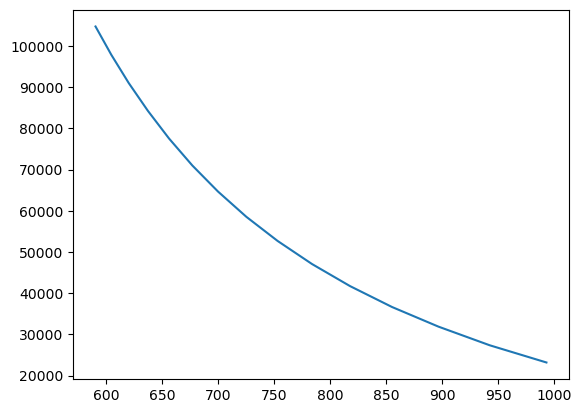

In [27]:

tecs = []

for p in los_ds.sat_pt:
    a = los_ds.alt.sel(sat_pt=p).values
    #print(a)
    e = los_ds.sel(sami_time=sami_time, sat_pt = p, method='nearest').edens.values
    #print(e)
    alt = []
    edens = []
    for i in range(len(a)):
        if a[i] <= 1000:
            alt.append(a[i])
            edens.append(e[i])

    t = np.trapz(edens, alt)/1e7
    plt.plot(alt, edens)
    #print(t)
    tecs.append(t)
    break
print(len(tecs))


In [16]:
# Plot the two on a map:

In [29]:
# The global data in this map ^^ uses the tec integrated from the ground to the highest alt I interpolated to. 
# Not great to compare to... Let's only take the stuff above grace:

In [13]:
#grace_est_tec = global_ds.sel(time=sami_time, 
#                              method='nearest').edens.where((global_ds.alt>500) & (global_ds.alt<=1000)).dropna('alt').integrate('alt')/1e7
grace_est_tec = global_ds.sel(time=sami_time, 
                              method='nearest').edens.where(global_ds.alt>500).dropna('alt').integrate('alt')/1e7
# Integrate global ds above GRACE altitudes.  steps:
# Select from the sami_time we want, then put NanN in where alt is too low, drop the NaN's, integrate by altitude, divide by 1e7


In [14]:
elev_mask = df_grace.Elevation_Angle > 50 # only use elevation more than 50º?

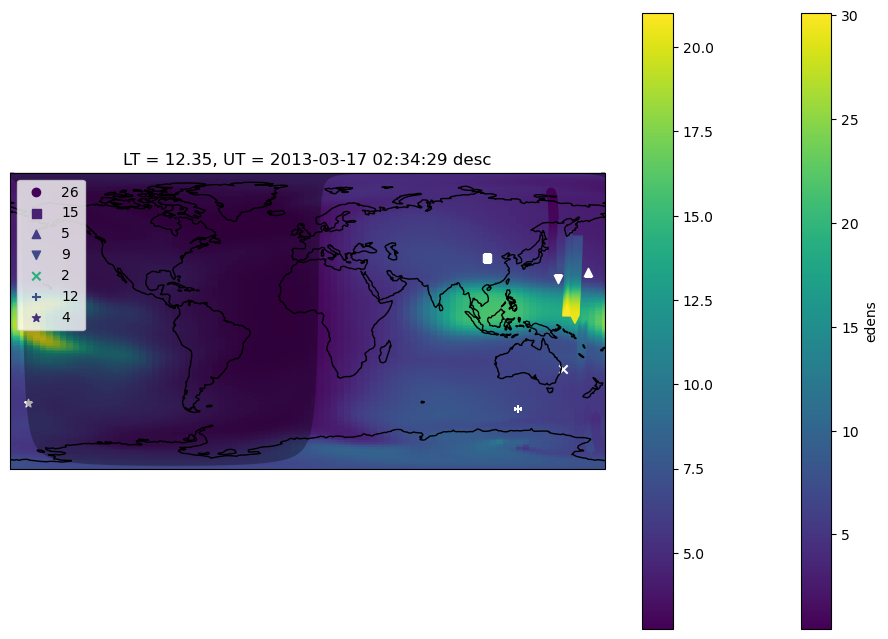

[26 15  5  9  2 12  4 25]
517
102
131
116
95
171
152
138


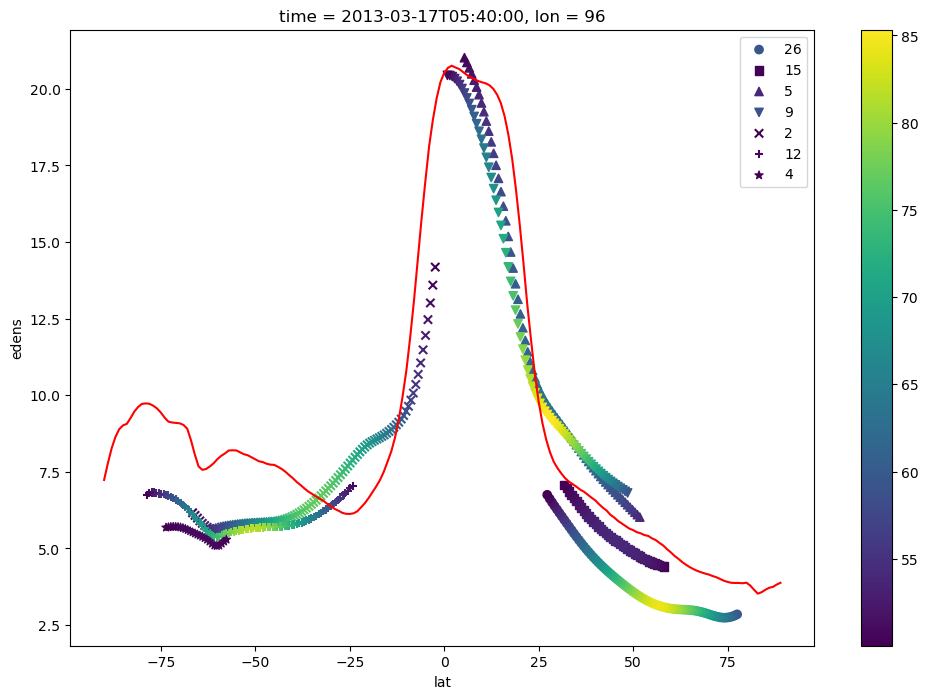

In [15]:
plt.figure(figsize=(12, 8))
ax = plt.subplot(projection=ccrs.PlateCarree())

grace_est_tec.plot(x='lon')

ax.coastlines()
ax.add_feature(Nightshade(sami_time), alpha=0.3)

nature = ' asc'
if df_grace.Latitude[0] > df_grace.Latitude[10]:
    nature = ' desc'

n = int(len(df_grace.LT)/2)
ax.set_title('LT = ' + str(df_grace.LT[n])[:5] + ', UT = ' + str(df_grace.date[n]) + nature)

prn = df_grace.PRN[elev_mask].unique()
shape = ['o', 's', '^', 'v', 'x', '+', '*']

for p, s, i in zip(prn, shape[:len(prn)], range(len(prn))):
    
    df_g1 = df_grace.iloc[np.where(df_grace.PRN == p)].reset_index(drop=True)
    ecef_geodetic = il.reload(ecef_geodetic)
    lat, lon, _ = ecef_geodetic.ecef_to_lla(df_g1.GPS_Position_X[0],df_g1.GPS_Position_Y[0],df_g1.GPS_Position_Z[0])
    elev_mask1 = df_g1.Elevation_Angle > 50
    
    plt.scatter(lon, lat, marker = s, c='w')
    plt.scatter(df_g1.Longitude[elev_mask1] + 5*i, df_g1.Latitude[elev_mask1], c=df_g1.tecs[elev_mask1], vmin = min(df_grace.tecs[elev_mask]), vmax = max(df_grace.tecs[elev_mask]), marker = s, transform=ccrs.PlateCarree(), label = p)
    
plt.legend()
plt.colorbar();
plt.show()


print(df_grace.PRN[elev_mask].unique())

# Could make this plot better, don't need to. 
#  Just wanted to check if the grace los tec was smoother. it is.


# Then only los points where elevation angle is under 50:


# It changes things A LOT!
print(len(df_grace.PRN[elev_mask]))

plt.figure(figsize=(12,8))
for p, s, i in zip(prn, shape[:len(prn)], range(len(prn))):
    
    df_g1 = df_grace.iloc[np.where(df_grace.PRN == p)].reset_index(drop=True)
    print(len(df_g1.PRN))
    elev_mask1 = df_g1.Elevation_Angle > 50
    
    plt.scatter(df_g1.Latitude[elev_mask1], df_g1.tecs[elev_mask1], c=df_g1.Elevation_Angle[elev_mask1], vmin = min(df_grace.Elevation_Angle[elev_mask]), vmax=max(df_grace.Elevation_Angle[elev_mask]), marker =s, label = p)

grace_est_tec.sel(lon=los_ds.lon.mean(), method='nearest').plot(color='red')

plt.legend()
plt.colorbar();
plt.show()

In [20]:
# Now take a look at comparing the distributions of [e-] by alt
#   from the global and los interpolated data

Maximum Alt of global_ds 2200
Minimum Alt of los_ds 619.8372221768182
Maximum Alt of los_ds 150


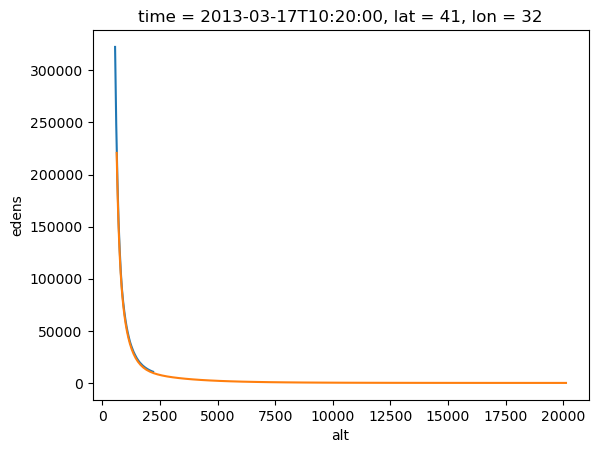

In [66]:
ptnum = 549 # change this to look at different points

# plt.plot(tecs)
global_ds.sel(lon=los_ds.lon.values[ptnum,0], 
                       lat=los_ds.lat.values[ptnum,0], 
                       time=sami_time,
                       method='nearest').edens.where(global_ds.alt>500).plot()

plt.plot(los_ds.alt.values[ptnum], los_ds.edens.sel(sami_time=sami_time).values[ptnum])

print('Maximum Alt of global_ds', max(global_ds.sel(lon = los_ds.lon.values[ptnum,0], time=sami_time, method='nearest').alt.values))
print('Minimum Alt of los_ds', min(los_ds.alt.values[ptnum]))
print('Maximum Alt of los_ds', min(global_ds.sel(lon = los_ds.lon.values[ptnum,0], time=sami_time, method='nearest').alt.values))


525


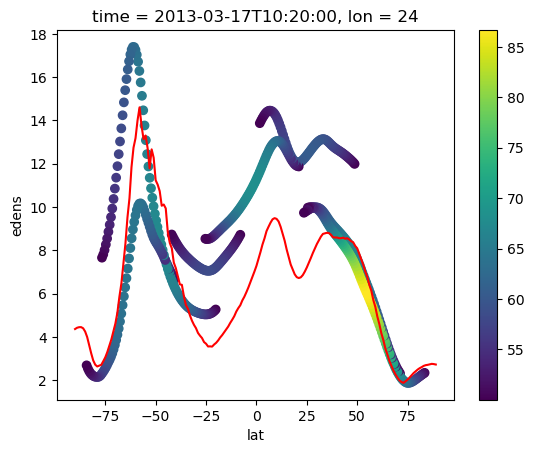

In [102]:
# Then only los points where elevation angle is under 50:

# It changes things A LOT!

plt.scatter(df_grace.Latitude[elev_mask], tecs[elev_mask], c=df_grace.Elevation_Angle[elev_mask])
grace_est_tec.sel(lon=los_ds.lon.mean(), method='nearest').plot(color='red')

plt.colorbar();

Going to stop here. Can't keep spending time on this. I've commented things up as best I could... Let me know if you have questions.


My takeaways:

- 50$^\circ$ might even be too low for an alevation angle mask.
    - that will severely limit the amount of data though
- The line-of-sight and global (vertically integrated TEC) seem pretty similar...
- As expected, line of sight is higher; it passes through more plasma.
- This is a single pass chosen at random. I got lucky (I think it's rare?) that it is directly under the GPS satellites.
    - With a similar process as I did, you should be able to adapt this code to run more orbits at once.
    - You can just change a few lines in a few cells to handle this. I may have time this weekend to help
- Would be interesting to see if there's any difference btwn graceA/B. Have we cheecked that yet?
- I have a lot of Madrigal line-of-sight TEC data we can compare these relationships we find to
- Need to try a dayside pass too...



But the two data are very similar. I think it is ok to say that the line-of-sight data come from the location of GRACE. UNLESS you check a dayside pass and find otherwise. It is possible things look different there.


Next step after doing something similar to what I did for a few more passes is going to be background removal. But we need to check more passes first.


>note: I wrote this code in such a way that you could follow my reasoning. Not everything is noteworthy, you don't have to run the cells that make uninformative plots.

>AND I wrote things such that you will be able to add more passes very easily. Do not start running these cells and changing the file that's read in for every sat pass. That's going to be annoying for you do do & probably waste time... I think you should be able to figure out how to get the interpolated data split back up into orbits and then these things plotted. In the cell where I reshaped the data, you will be able to add another dimension for `orbit_num` (calculated from when you split orbits) and change the hard-coded values of 1917 to something either computed automatically or typed in. Doesn't matter if things spill over a bit (orbits won't have the exact same numbers of points) since we can't use polar data anyways.